# Visualisation of Probabilistic Model Manifold 

InPCA was conceived to ameliorate the orthogonality problem in visualising manifold with $n$-sphere embedding by taking the replica limit $n\rightarrow 0$. This mathematical trick modifies the entries of thedata matrix (Hellinger distance) into a distance function proportional to Bhattacharya distance which is unbounded from above. Eigenvalue decomposition is subsequently employed to determine the projection vectors for visualization purposes. This note extends the usage of SVD to other distance functions.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import proj3d
from scipy import *
from numpy import linalg as LA

In [2]:
def plot3D(px,py,pz,clist,emphPoints = [],cmap='plasma',shadow=False,useCMAP = True):
    
    elev = 30
    azim = 60

    viewVect = [np.cos(np.pi*180/elev)*np.sin(np.pi*180/azim),np.cos(np.pi*180/elev)*np.cos(np.pi*180/azim),np.cos(np.pi*180/elev)]

    p = np.array([px,py,pz])
    dots = np.array(np.dot(viewVect,p))
    sort = dots.argsort()

    px = px[sort]
    py = py[sort]
    pz = pz[sort]
    clist = np.array(clist)[sort]

    mean_x = px.min()
    mean_y = py.min()
    mean_z = pz.min()

    Xdist = px.max() - px.min()
    Xcntr = (px.max() + px.min())/2.0
    Ydist = py.max() - py.min()
    Ycntr = (py.max() + py.min())/2.0
    Zdist = pz.max() - pz.min()
    Zcntr = (pz.max() + pz.min())/2.0

    dist = 0.6*max(Xdist,Ydist,Zdist)

    fig = plt.figure(figsize = (10,10))
    ax = fig.gca(projection='3d')
    #ax.view_init(30,-60)

    listTemp = [i for i in range(len(px))]

    if useCMAP:
        ax.scatter(px,py,pz,c=clist,edgecolor='black',linewidth=0.2,cmap = cmap)
    else:
        ax.scatter(px,py,pz,c=clist,edgecolor='black',linewidth=0.2)
    
    for p in emphPoints:
        ax.scatter([px[p]],[py[p]],[pz[p]],c='C1',s=100)

    ax.set_xlim([Xcntr - dist, Xcntr + dist])
    ax.set_ylim([Ycntr - dist, Ycntr + dist])
    ax.set_zlim([Zcntr - dist, Zcntr + dist])

    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])

    #ax.set_axis_off()
    #plt.show()
    
    if shadow:
        #fig = plt.figure(figsize = (10,10))
        #ax = fig.gca(projection='3d')
        #ax.view_init(30,-60)
        
        ax.scatter(px,py,[Zcntr - dist for p in pz],c='black',alpha=0.01)
        ax.scatter(px,[Ycntr + dist for p in py],pz,c='black',alpha=0.01)
        ax.scatter([Xcntr - dist for p in px],py,pz,c='black',alpha=0.01)

        ax.set_xlim([Xcntr - dist, Xcntr + dist])
        ax.set_ylim([Ycntr - dist, Ycntr + dist])
        ax.set_zlim([Zcntr - dist, Zcntr + dist])

        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_zticks([])

        #ax.set_axis_off()
    plt.show()
    
def trianglePlot(arry,metric_sig,clist,emphPoints = [],dim=2):
    
    ranges = [arry[:,idx].max()-arry[:,idx].min() for idx in range(dim+1)]
    axesDist = 0.6*max(ranges)
    
    figs,axs = plt.subplots(nrows=dim,ncols=dim,figsize=(15,15))
    for row in range(dim-1,-1,-1):
        for col in range(dim-1,-1,-1):
            if col >= row:
                py = arry[:,row]
                px = arry[:,col+1]
                
                centerX = (px.max()+px.min())/2
                centerY = (py.max()+py.min())/2
                
                sc1 = axs[row,col].scatter(px,py,s=5,c=clist,edgecolor='black',linewidth=0.2, cmap='plasma')
                for p in emphPoints:
                    axs[row,col].scatter([px[0]],[py[0]],s=100,c='C1',edgecolor='black',linewidth=0.2)
                
                axs[row,col].set_xlim([centerX-axesDist,centerX+axesDist])
                axs[row,col].set_ylim([centerY-axesDist,centerY+axesDist])
                if row != col:
                    axs[row,col].set_xticks([])
                    axs[row,col].set_yticks([])
                if row == col:
                    axs[row,col].set_ylabel('direction '+str(row+1))
                    axs[row,col].set_xlabel('direction '+str(col+2))
                    if metric_sig[row]<0:
                        axs[row,col].yaxis.label.set_color('red')
                    if metric_sig[col+1]<0:
                        axs[row,col].xaxis.label.set_color('red')
                axs[row,col].ticklabel_format(style='sci',scilimits=(-2,2),axis='both')
            else:
                axs[row,col].axis('off')
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()

In [3]:
def hyperboloid_pairwise_distance(mu1,sigma1,mu2,sigma2):
    return ((mu1-mu2)**2+2*(sigma1-sigma2)**2)/(2*sigma1*sigma2)

def SymKL(mu1,sigma1,mu2,sigma2):
    return ((sigma1**2-sigma2**2)**2+(mu1-mu2)**2*(sigma1**2+sigma2**2))/(2*sigma1**2*sigma2**2)

def geodesic(mu1,mu2,sigma1,sigma2):
    return arccosh(cosh(sigma1)*cosh(mu2-mu1)*cosh(sigma2)-sinh(sigma1)*sinh(sigma2))**2

def logDotProd(mu1,sigma1,mu2,sigma2):
    return log(2*sigma1*sigma2)/2-log(sigma1**2+sigma2**2)/2-1/4*(mu1-mu2)**2/(sigma1**2+sigma2**2)

def dotProd(mu1,sigma1,mu2,sigma2):
    return sqrt((2*sigma1*sigma2)/(sigma1**2+sigma2**2))*exp(-1/4*(mu1-mu2)**2/(sigma1**2+sigma2**2))

In [4]:
muRange = linspace(-1,1,50)
sigmaRange = 10**np.linspace(-1,1,50)
pairs = [[mu,sigma] for mu in muRange for sigma in sigmaRange]

# Pairwise distance: $d^{2}(\mu_{1},\sigma_{1},\mu_{2},\sigma_{2})=\frac{(\mu_{1}-\mu_{2})^{2}+2(\sigma_{1}-\sigma_{2})^{2}}{2\sigma_{1} \sigma_{2}}$

In [5]:
W = [[hyperboloid_pairwise_distance(mu1,sigma1,mu2,sigma2) for mu1,sigma1 in pairs] for mu2,sigma2 in pairs]
W_sum = [sum(row)/len(row) for row in W]
W_sum_sums = sum(W_sum)/len(W)
CovMat = [[W[i][j]-W_sum[i] - W_sum[j] + W_sum_sums for i in range(len(W))] for j in range(len(W))]

In [6]:
w,vt = LA.eig(CovMat)
metric_sig=sign(w.real)
print(w[0:8].real)
w = abs(w[0:8].real)
v = vt.T.real[0:8]
projMatEigs = dot(v.T,diag(sqrt(w)))

[-2.26184801e+04 -1.01224218e+04  9.10200574e+03 -3.62958295e-12
  2.37552732e-12  2.37552732e-12 -1.10025837e-12 -1.10025837e-12]


Text(0,0.5,'$\\lambda_{i}$')

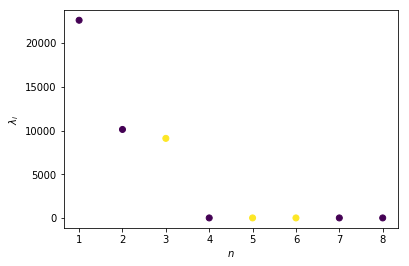

In [7]:
cs=[metric_sig[i] for i in range(len(w))]
plt.scatter(linspace(1,len(w),len(w)),(w),c=cs)
plt.xlabel('$n$')
plt.ylabel(r'$\lambda_{i}$')

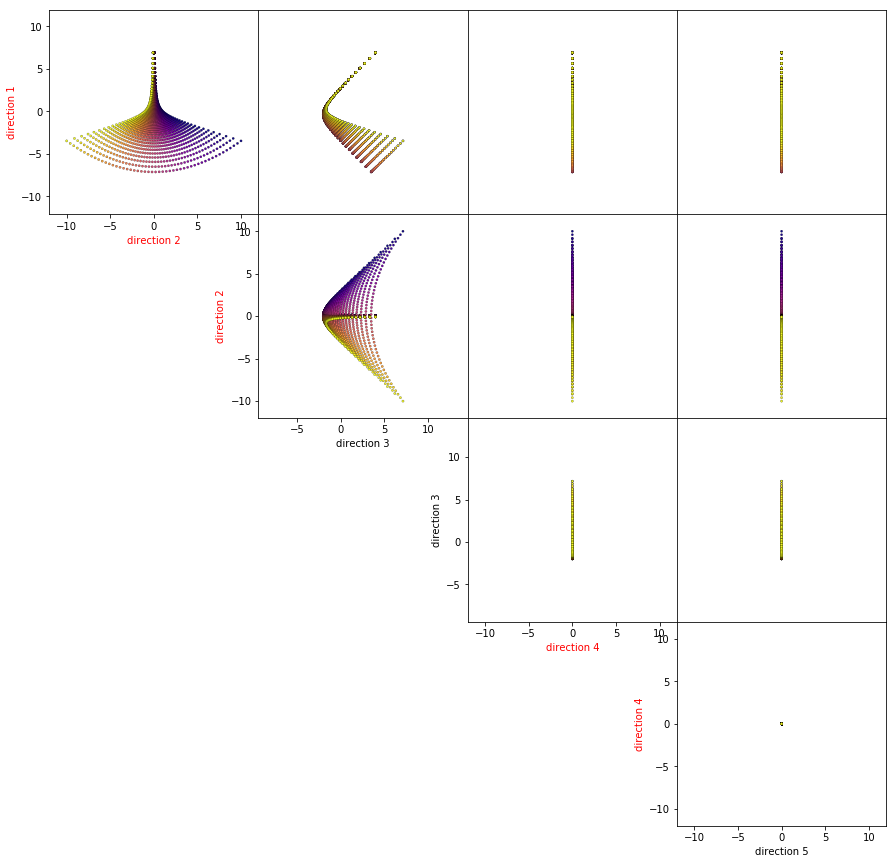

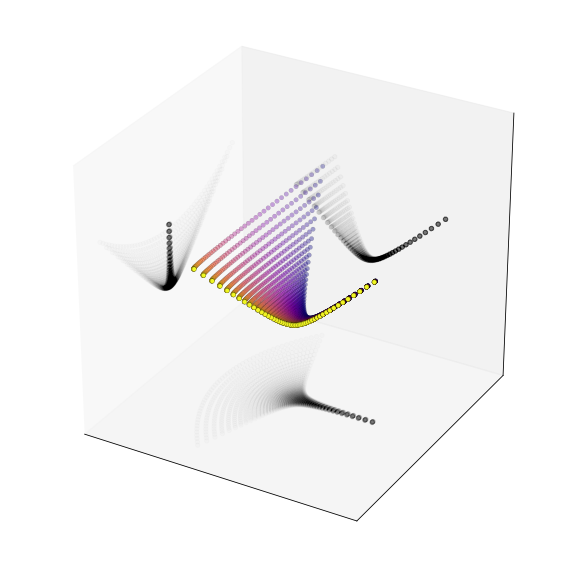

In [8]:
trianglePlot(projMatEigs,metric_sig,[mu for mu,sigma in pairs],dim=4)
plot3D(projMatEigs[:,0],projMatEigs[:,1],projMatEigs[:,2],[mu for mu,sigma in pairs],shadow=True)


# Symmetricized Kullback Lieber Divergence

In [9]:
W_KL = [[SymKL(mu1,sigma1,mu2,sigma2) for mu1,sigma1 in pairs] for mu2,sigma2 in pairs]
W_KL_sum = [sum(row)/len(row) for row in W_KL]
W_KL_sum_sums = sum(W_KL_sum)/len(W)
CovMat = [[W_KL[i][j]-W_KL_sum[i] - W_KL_sum[j] + W_KL_sum_sums for i in range(len(W_KL))] for j in range(len(W_KL))]

In [10]:
w_kl,vt_kl = LA.eig(CovMat)
metric_sig=sign(w_kl.real)
print(w_kl[0:8].real)
w_kl = abs(w_kl[0:8].real)
v_kl = vt_kl.T.real[0:8]
projMatEigs_kl = dot(v_kl.T,diag(sqrt(w_kl)))

[-7.96637065e+05  4.58632318e+05 -3.20349353e+04  1.17900917e+04
  7.44974635e-11 -6.37949683e-11 -6.37949683e-11 -6.80872023e-11]


Text(0,0.5,'$\\lambda_{i}$')

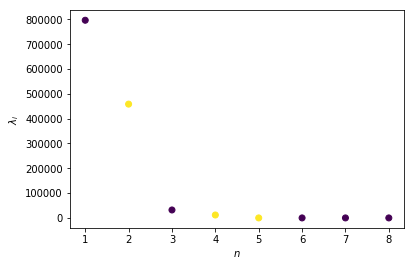

In [11]:
cs=[metric_sig[i] for i in range(len(w_kl))]
plt.scatter(linspace(1,len(w_kl),len(w_kl)),(w_kl),c=cs)
plt.xlabel('$n$')
plt.ylabel(r'$\lambda_{i}$')

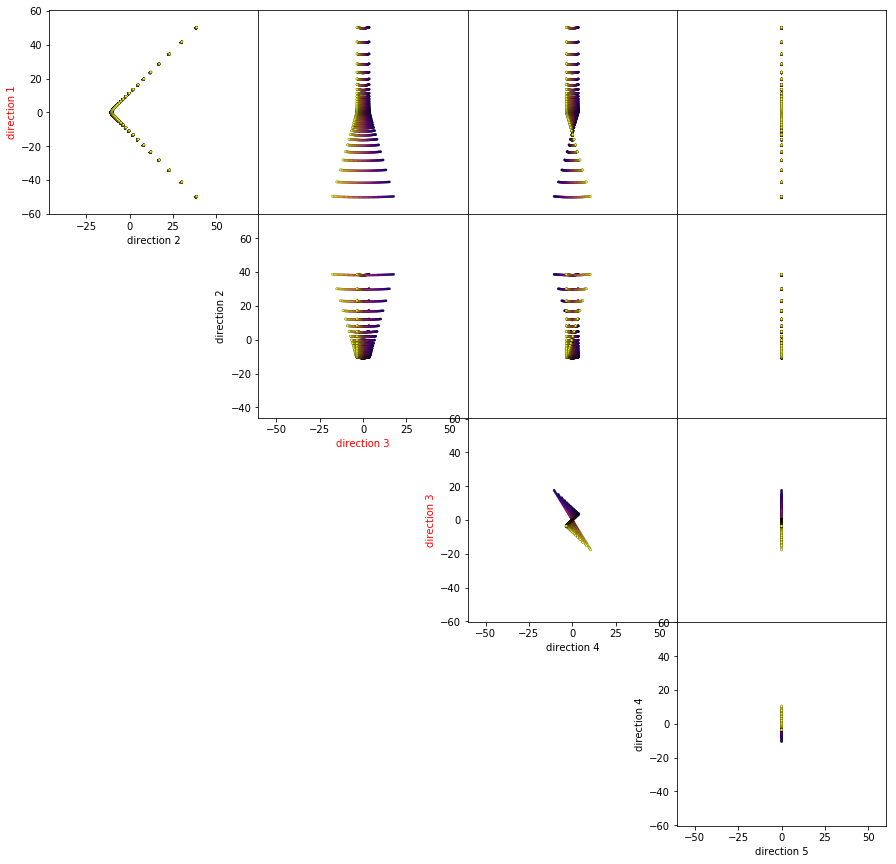

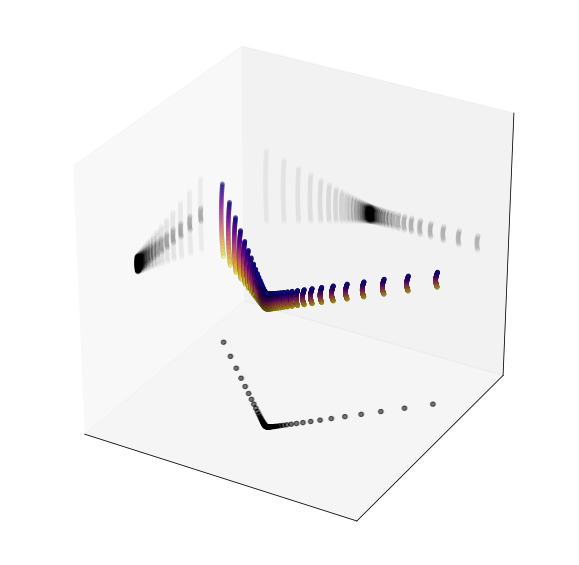

In [12]:
trianglePlot(projMatEigs_kl,metric_sig,[mu for mu,sigma in pairs],dim=4)
plot3D(projMatEigs_kl[:,0],projMatEigs_kl[:,1],projMatEigs_kl[:,2],[mu for mu,sigma in pairs],shadow=True)


# Geodesic 

In [13]:
W_geo = [[geodesic(mu1,sigma1,mu2,sigma2) for mu1,sigma1 in pairs] for mu2,sigma2 in pairs]
W_geo_sum = [sum(row)/len(row) for row in W_geo]
W_geo_sum_sums = sum(W_geo_sum)/len(W_geo)
CovMat_geo = [[W_geo[i][j]-W_geo_sum[i] - W_geo_sum[j] + W_geo_sum_sums for i in range(len(W_geo))] for j in range(len(W_geo))]

In [14]:
w_geo,vt_geo = LA.eig(CovMat_geo)
metric_sig=sign(w_geo.real)
print(w_geo[0:8].real)
w_geo = abs(w_geo[0:8].real)
v_geo = vt_geo.T.real[0:8]
projMatEigs_geo = dot(v_geo.T,diag(sqrt(w_geo)))

[ 2.95970475e+04  3.36161671e+01  3.36161671e+01  1.88765106e+00
  6.56141021e-03  6.56141021e-03 -4.93451717e-04 -1.91268889e-04]


Text(0,0.5,'$\\lambda_{i}$')

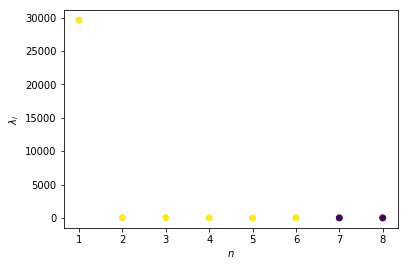

In [15]:
cs=[metric_sig[i] for i in range(len(w_geo))]
plt.scatter(linspace(1,len(w_geo),len(w_geo)),(w_geo),c=cs)
plt.xlabel('$n$')
plt.ylabel(r'$\lambda_{i}$')

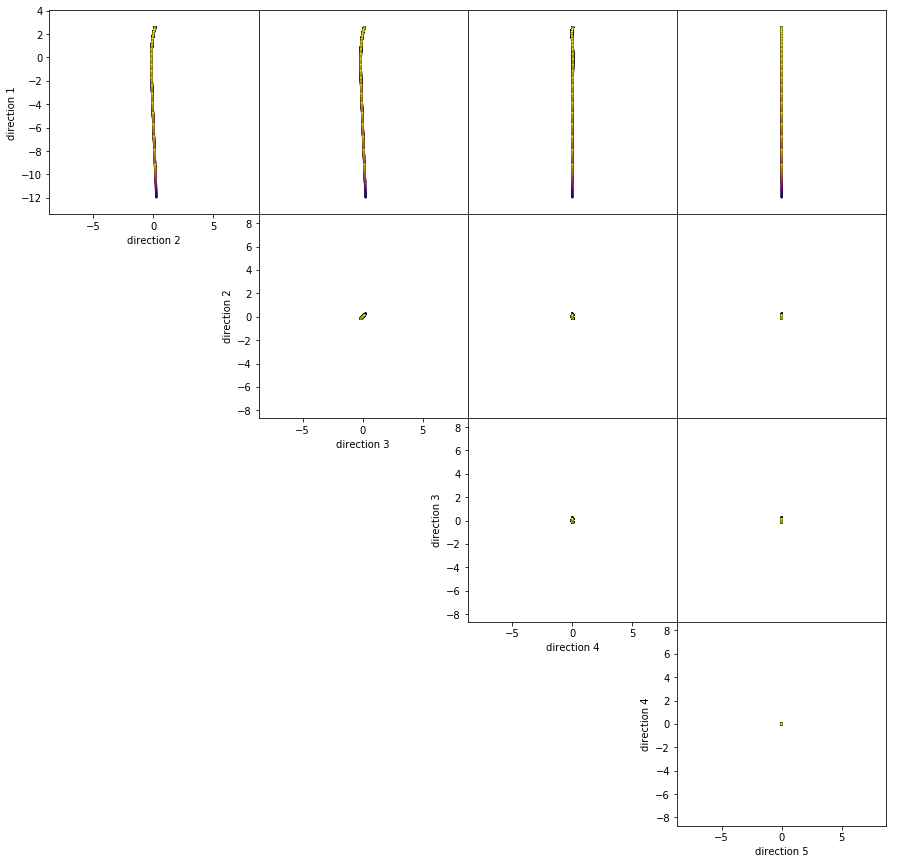

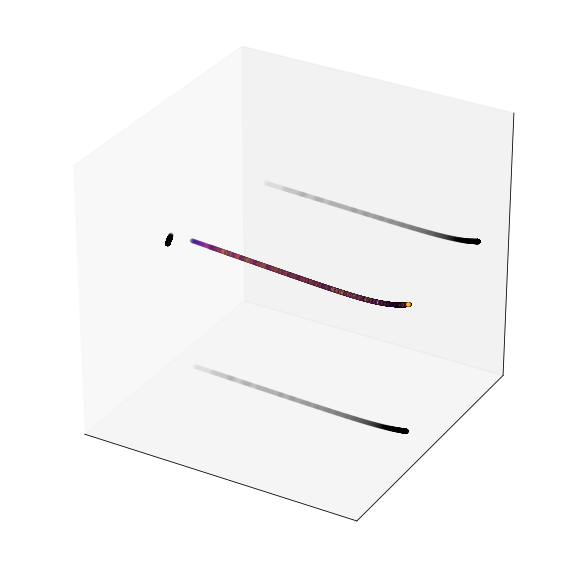

In [16]:
trianglePlot(projMatEigs_geo,metric_sig,[mu for mu,sigma in pairs],dim=4)
plot3D(projMatEigs_geo[:,0],projMatEigs_geo[:,1],projMatEigs_geo[:,2],[mu for mu,sigma in pairs],shadow=True)

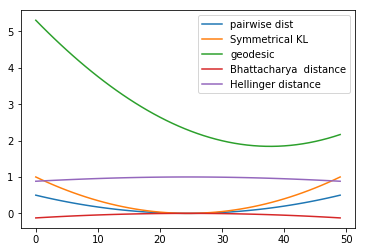

In [17]:
plt.plot(hyperboloid_pairwise_distance(0,1,muRange,1),label='pairwise dist')
plt.plot(SymKL(0,1,muRange,1),label='Symmetrical KL')
plt.plot(geodesic(0,1,muRange,1),label='geodesic')
plt.plot(logDotProd(0,1,muRange,1),label='Bhattacharya  distance')
plt.plot(dotProd(0,1,muRange,1),label='Hellinger distance')
plt.legend()

[10, 20, 0, 20]

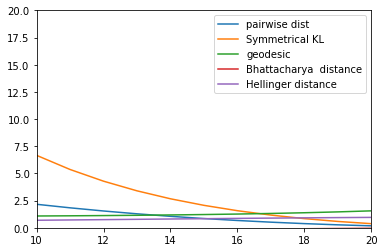

In [18]:
plt.plot(hyperboloid_pairwise_distance(0,1,0,sigmaRange),label='pairwise dist')
plt.plot(SymKL(0,1,0,sigmaRange),label='Symmetrical KL')
plt.plot(geodesic(0,1,0,sigmaRange),label='geodesic')
plt.plot(logDotProd(0,1,0,sigmaRange),label='Bhattacharya  distance')
plt.plot(dotProd(0,1,0,sigmaRange),label='Hellinger distance')
plt.legend()
plt.axis([10,20,0,20])